In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
from re import sub
from decimal import Decimal

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
import keras.backend as K
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.callbacks  import EarlyStopping
from tensorflow.keras.layers import Dropout

In [2]:
df = pd.read_csv('car_m_v_dataset.csv', skiprows=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   brand                    160 non-null    object 
 1   model                    160 non-null    object 
 2   year                     160 non-null    int64  
 3   segment                  160 non-null    object 
 4   max                      160 non-null    object 
 5   min                      160 non-null    object 
 6   adult_passangers         160 non-null    int64  
 7   weight                   160 non-null    int64  
 8   transmission             160 non-null    object 
 9   fuel                     160 non-null    object 
 10  tank                     160 non-null    object 
 11  fuel_consumption         159 non-null    float64
 12  length                   160 non-null    float64
 13  width                    160 non-null    float64
 14  height                   1

In [3]:
def normalize_segments(raw_segment):
    segments = dict(
        city_values = ['Ciudad'],
        sed_s_values = ['Sedan-SmallSize'],
        sed_m_values = ['Sedan-MidSize', 'Sedan/MidSize/Hybrid'],
        sed_f_values = ['Sedan-FullSize','Sedan-Fullsize*', 'Sedan-FullSize/Hybrid', 'Sedan-Fullsize'],
        suv_s_values = ['SUV-City', 'SUV-SmallSize'],
        suv_m_values = ['SUV-MidSize'] ,
        suv_f_values = ['SUV-Fullsize', 'SUV-Fullsize/Hybrid', 'SUV-FullSize'],
        suv_xl_values = ['SUV-ExtendedSize','SUV-ExtendedSize/Hybrid'],
        pu_s_values = ['Pickup-SmallSize'],
        pu_m_values = ['Pickup-MidSize'],
        pu_f_values = ['Pickup-FullSize/Hybrid', 'Pickup-FullSize'],
        mini_van_values = ['MiniVan', 'MiniVan/Hybrid']
        
    )
    for k, values in segments.items():
        try:
            if values.index(raw_segment) >= 0:
                return k[:-7]
        except ValueError:
            continue
    
    print('raw_segment: [{}]not found.'.format(raw_segment))
    return 'Not found'
    
df['segment_normalized'] = df['segment'].apply(normalize_segments)

In [4]:
def category_classifer(raw_segment):
    segments = dict(
        city_values = ['Ciudad'],
        sedan_values = [
            'Sedan-SmallSize', 'Sedan-MidSize', 'Sedan/MidSize/Hybrid', 
            'Sedan-FullSize','Sedan-Fullsize*', 'Sedan-FullSize/Hybrid', 'Sedan-Fullsize'
        ],
       
        suv_values = [
            'SUV-City', 'SUV-SmallSize', 'SUV-MidSize', 
            'SUV-Fullsize', 'SUV-Fullsize/Hybrid', 
            'SUV-FullSize','SUV-ExtendedSize', 'SUV-ExtendedSize/Hybrid'
        ],
       
        pu_values = ['Pickup-SmallSize', 'Pickup-MidSize', 'Pickup-FullSize/Hybrid', 'Pickup-FullSize', ],
        mini_van_values = ['MiniVan', 'MiniVan/Hybrid']
        
    )
    for k, values in segments.items():
        try:
            if values.index(raw_segment) >= 0:
                return k[:-7]
        except ValueError:
            continue
    
    print('category: [{}]not found.'.format(raw_segment))
    return 'Not found'

df['category'] = df['segment'].apply(category_classifer)


In [5]:
def ground_category(raw_segment):
    segments = dict(
        city_values = ['Ciudad'],
        sedan_values = [
            'Sedan-SmallSize', 'Sedan-MidSize', 'Sedan/MidSize/Hybrid', 
            'Sedan-FullSize','Sedan-Fullsize*', 'Sedan-FullSize/Hybrid', 'Sedan-Fullsize'
        ],
       
        suv_values = [
            'SUV-City', 'SUV-SmallSize', 'SUV-MidSize', 'SUV-MidSize' 
            'SUV-Fullsize', 'SUV-Fullsize/Hybrid', 
            'SUV-FullSize','SUV-ExtendedSize', 'SUV-ExtendedSize/Hybrid'
        ],
       
        pu_values = ['Pickup-SmallSize', 'Pickup-MidSize', 'Pickup-FullSize/Hybrid', 'Pickup-FullSize', ],
        mini_van_values = ['MiniVan', 'MiniVan/Hybrid']
        
    )
    for k, values in segments.items():
        try:
            if values.index(raw_segment) >= 0:
                return k[:-7]
        except ValueError:
            continue
    
    print('category: [{}]not found.'.format(raw_segment))
    return 'Not found'

df['category'] = df['segment'].apply(category_classifer)

In [6]:

main_columns = ['brand', 'model']
filtered_df = df[df['dist_axis'].isna()]

df_groupby = df.groupby(['segment_normalized'])['dist_axis'].mean()




print('dist_axis missing values: {}'.format(df['dist_axis'].isnull().sum()))

def fill_missing_dist_axis(row):
    if np.isnan(row['dist_axis']):
        return df_groupby[row['segment_normalized']]
    else:
        return row['dist_axis']



df['dist_axis'] = df.apply(lambda row: fill_missing_dist_axis(row), axis=1)

print('dist_axis missing values: {}'.format(df['dist_axis'].isnull().sum()))
df['dist_axis'] 

dist_axis missing values: 0
dist_axis missing values: 0


0      2.60
1      2.60
2      2.60
3      2.60
4      2.60
       ... 
155    2.81
156    2.81
157    2.81
158    2.90
159    2.27
Name: dist_axis, Length: 160, dtype: float64

<Axes: xlabel='segment_normalized', ylabel='length'>

/Users/luisbarreras/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/luisbarreras/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/luisbarreras/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


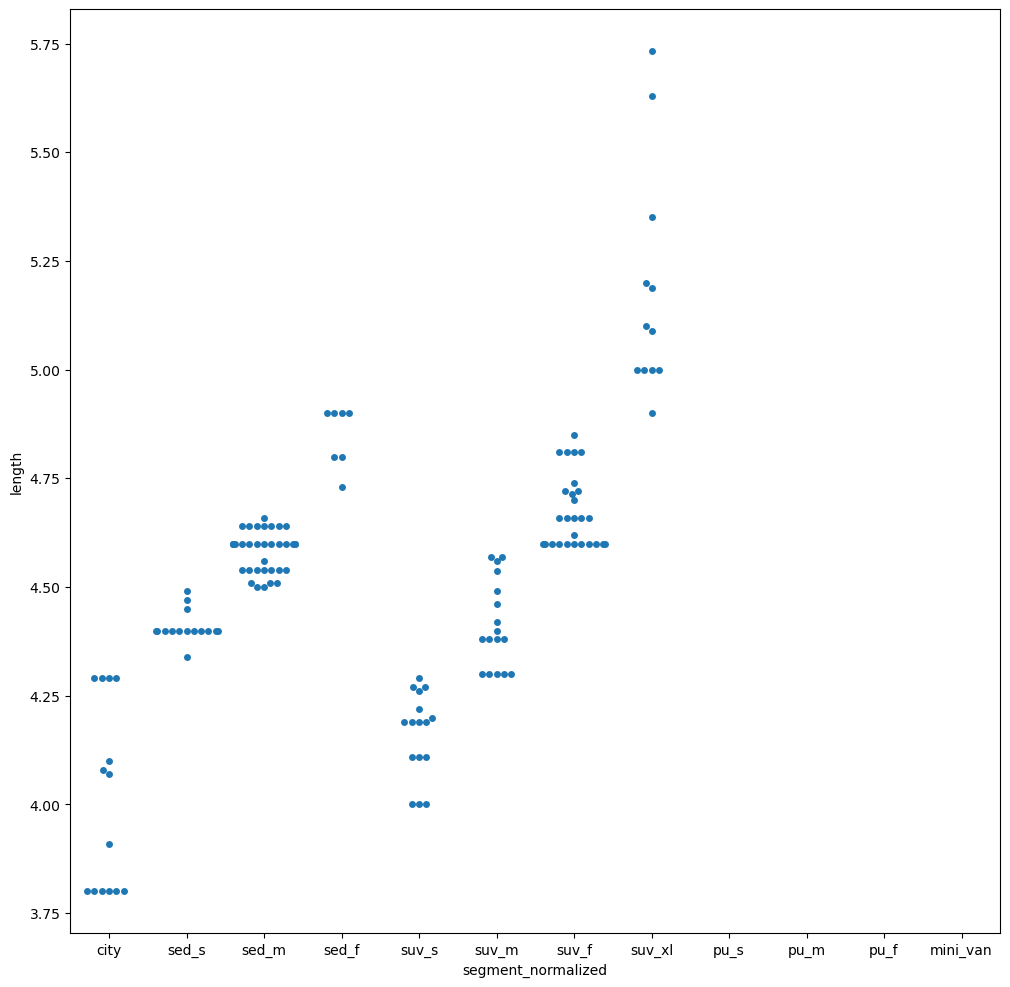

In [7]:
order_labels =[
    'city', 
    'sed_s', 'sed_m', 'sed_f',
    'suv_s', 'suv_m', 'suv_f', 'suv_xl',
    'pu_s', 'pu_m','pu_f',
    'mini_van'
]

plt.figure(figsize=(12,12))

df_suv_sedan = df[df['segment_normalized'].isin(['sed_s', 'sed_m', 'sed_f', 'suv_s', 'suv_m', 'suv_f', 'suv_xl', 'city'])]



sns.swarmplot(x='segment_normalized', y='length', data=df_suv_sedan, order=order_labels)




/Users/luisbarreras/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


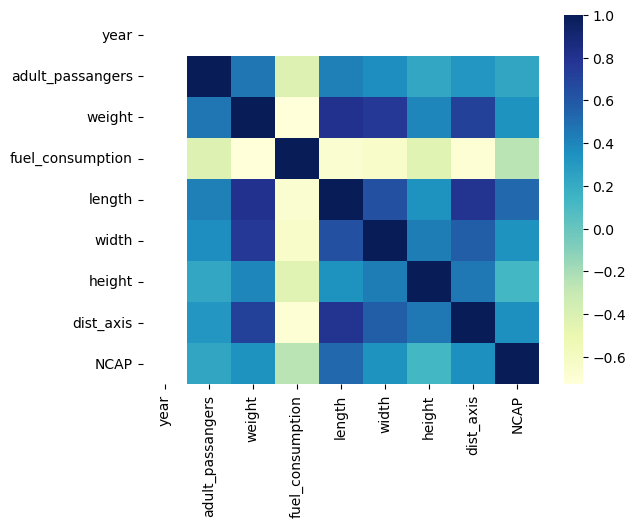

In [13]:
# sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis')
dataplot = sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True) 



## Transformations of data

In [14]:
df['min_price'] = df['min'].apply(lambda x:Decimal(sub(r'[^\d.]', '', x) ))
df['trunk_size_number'] = df['trunk_size'].apply(lambda x:Decimal(sub(r'[^\d.]', '', x) ))
df['transmission_automatic'] = df['transmission'].apply(lambda x: 1 if 'A' in x else 0)
df['weight_number'] = df['weight'].apply(lambda x:Decimal(sub(r'[^\d.]', '', str(x)) ))


cast_boolean = lambda x: 1 if x == 'yes' else 0

# Yes/No Columns
df['car_tow'] = df['car_tow'].apply(cast_boolean)


In [15]:


def cast_height_to_ground(ground):
    value = ground.split('/')[0]
    switcher = {
        'normal': 0,
        'high': 1,
        'extra_high': 2
    }

    return switcher.get(value)

df['ground_clearance'] = df['height_to_the ground'].apply(cast_height_to_ground)


In [16]:
# Delete columns not needed
df = df.drop(columns=[
    'body_type', 'segment', 'max', 'min', 'transmission', 'brand', 'model', 'year', 'weight', 'trunk_size',
    'front_break', 'rear_break', 'braking_assists', 'fuel',
    '4x4/awd', 'big_volume_cargo', 'height_to_the ground', 'tank',
     'front_airbags',	'side_airbags',	'curtain_air_bags',	'knee_air_bags',
    'tire_pressure_monitor', 'emergency_brake',	'reverse_camera','camera_360',
    'bluetooth', 'android_auto/apple+play', 'cruise_control', 'cruise_control_advanced',
    'blind_spot_alert', 'rain_sensor', 'NCAP',  'transmission_automatic', 'car_pull', 'tank_number',
    'width', 'car_tow',  'weight_number'
    ],
errors='ignore')

 

df.head(5)

,adult_passangers,fuel_consumption,length,height,dist_axis,segment_normalized,category,min_price,trunk_size_number,ground_clearance
0,5,20.0,4.4,1.4,2.6,sed_s,sedan,316100,475,0
1,5,20.0,4.4,1.4,2.6,sed_s,sedan,331100,475,0
2,5,20.0,4.4,1.4,2.6,sed_s,sedan,341000,475,0
3,5,20.0,4.4,1.4,2.6,sed_s,sedan,356000,475,0
4,5,20.0,4.4,1.4,2.6,sed_s,sedan,392200,475,0


In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

numeric_columns = ['adult_passangers', 'fuel_consumption', 'trunk_size_number', 'length',
                    'min_price', 'height',  'ground_clearance', 'dist_axis'
                  ]
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
df.head(14)



,adult_passangers,fuel_consumption,length,height,dist_axis,segment_normalized,category,min_price,trunk_size_number,ground_clearance
0,0.5,0.599604,0.285714,0.046243,0.150685,sed_s,sedan,0.028334,0.176381,0.0
1,0.5,0.599604,0.285714,0.046243,0.150685,sed_s,sedan,0.037554,0.176381,0.0
2,0.5,0.599604,0.285714,0.046243,0.150685,sed_s,sedan,0.043639,0.176381,0.0
3,0.5,0.599604,0.285714,0.046243,0.150685,sed_s,sedan,0.052858,0.176381,0.0
4,0.5,0.599604,0.285714,0.046243,0.150685,sed_s,sedan,0.075108,0.176381,0.0
5,0.5,0.500496,0.380952,0.046243,0.196347,sed_m,sedan,0.092133,0.118601,0.0
6,0.5,0.500496,0.380952,0.046243,0.196347,sed_m,sedan,0.110572,0.118601,0.0
7,0.5,0.500496,0.380952,0.046243,0.196347,sed_m,sedan,0.147449,0.118601,0.0
8,0.5,0.500496,0.380952,0.046243,0.196347,sed_m,sedan,0.159742,0.118601,0.0
9,0.5,0.500496,0.476190,0.046243,0.242009,sed_f,sedan,0.185556,0.152053,0.0


In [18]:
df.columns

Index(['adult_passangers', 'fuel_consumption', 'length', 'height', 'dist_axis',
       'segment_normalized', 'category', 'min_price', 'trunk_size_number',
       'ground_clearance'],
      dtype='object')

## SGD Classifier

In [19]:
suv_sedan_cars = ['sed_s', 'sed_m', 'sed_f', 'suv_s', 'suv_m', 'suv_f', 'suv_xl', 'city']
df_suv_sedan = df[df['segment_normalized'].isin(suv_sedan_cars)]
X = df_suv_sedan.drop(columns=[
    'segment_normalized',
    'category'
    ])

X.fillna(0, inplace=True)
y = df_suv_sedan['segment_normalized']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.2)

# Create classifier
clf = SGDClassifier(loss='log_loss', 
                    random_state=717,
                     alpha=0.0001,
                    max_iter=1000)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       sed_m       1.00      1.00      1.00         9
       sed_s       1.00      1.00      1.00         3
       suv_f       0.88      1.00      0.93         7
       suv_m       1.00      1.00      1.00         5
       suv_s       0.00      0.00      0.00         1
      suv_xl       1.00      1.00      1.00         4

    accuracy                           0.97        29
   macro avg       0.81      0.83      0.82        29
weighted avg       0.94      0.97      0.95        29



/Users/luisbarreras/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisbarreras/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisbarreras/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



## SGD for Categories City, Sedan & SUV


In [20]:
df_suv_sedan = df[df['category'].isin(['sedan', 'city', 'suv'])]

print(df_suv_sedan.info())
X = df_suv_sedan.drop(columns=[
    'segment_normalized', 'category'
    ])

X.fillna(0, inplace=True)

y = df_suv_sedan['category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.3)

# Create classifier
clf = SGDClassifier(loss='log_loss', alpha=0.0001,
                    max_iter=10000)

# Train the classifier
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

conf_matrix = confusion_matrix(y_test, y_pred)
## print(classification_report(y_test, y_pred))

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 0 to 159
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   adult_passangers    143 non-null    float64
 1   fuel_consumption    142 non-null    float64
 2   length              143 non-null    float64
 3   height              143 non-null    float64
 4   dist_axis           143 non-null    float64
 5   segment_normalized  143 non-null    object 
 6   category            143 non-null    object 
 7   min_price           143 non-null    float64
 8   trunk_size_number   143 non-null    float64
 9   ground_clearance    143 non-null    float64
dtypes: float64(8), object(2)
memory usage: 12.3+ KB
None
Accuracy: 0.9534883720930233



## Neuronal Network for Categories City, Sedan & SUV


In [21]:
# Data preparation
df_suv_sedan = df[df['category'].isin(['sedan', 'city', 'suv'])]

print(df_suv_sedan.info())
X = df_suv_sedan.drop(columns=[
    'segment_normalized', 'category'
    ])

X.fillna(0, inplace=True)

y = df_suv_sedan['category']

# convert classes to one hot encoded
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
print('encoded',encoded_Y)
one_hot_y = to_categorical(encoded_Y, num_classes=None)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
	X, one_hot_y, test_size=0.3)

# Create Neuronal model
model = Sequential()
model.add(Dense(10, activation ='relu'))
model.add(Dense(7, activation ='relu'))
model.add(Dense(5, activation ='relu'))
model.add(Dense(3, activation ='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = 'adam')

# Train the classifier
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
model.fit(x=X_train, y = y_train, epochs=800, validation_data=(X_test, y_test), callbacks = [early_stop])

# Validate results
y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(classification_report(y_test, y_pred))

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 0 to 159
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   adult_passangers    143 non-null    float64
 1   fuel_consumption    142 non-null    float64
 2   length              143 non-null    float64
 3   height              143 non-null    float64
 4   dist_axis           143 non-null    float64
 5   segment_normalized  143 non-null    object 
 6   category            143 non-null    object 
 7   min_price           143 non-null    float64
 8   trunk_size_number   143 non-null    float64
 9   ground_clearance    143 non-null    float64
dtypes: float64(8), object(2)
memory usage: 12.3+ KB
None
encoded [1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 0 1 1
 1 2 2 2 2 2 2 2 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 1 0 1 1 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 1 1 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 

2024-07-20 14:05:19.417406: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 0s 22ms/step - loss: 1.0639 - val_loss: 1.0637
Epoch 2/800
4/4 [==============================] - 0s 4ms/step - loss: 1.0564 - val_loss: 1.0577
Epoch 3/800
4/4 [==============================] - 0s 3ms/step - loss: 1.0487 - val_loss: 1.0520
Epoch 4/800
4/4 [==============================] - 0s 4ms/step - loss: 1.0416 - val_loss: 1.0463
Epoch 5/800
4/4 [==============================] - 0s 4ms/step - loss: 1.0346 - val_loss: 1.0408
Epoch 6/800
4/4 [==============================] - 0s 4ms/step - loss: 1.0280 - val_loss: 1.0358
Epoch 7/800
4/4 [==============================] - 0s 4ms/step - loss: 1.0219 - val_loss: 1.0306
Epoch 8/800
4/4 [==============================] - 0s 4ms/step - loss: 1.0151 - val_loss: 1.0254
Epoch 9/800
4/4 [==============================] - 0s 4ms/step - loss: 1.0093 - val_loss: 1.0201
Epoch 10/800
4/4 [==============================] - 0s 4ms/step - loss: 1.0021 - val_loss: 1.0150
Epoch 11/800
4/4 [======================

## Neuronal Network for Segment normalized


In [34]:


# Data preparation
suv_sedan_cars = ['sed_s', 'sed_m', 'sed_f', 'suv_s', 'suv_m', 'suv_f', 'suv_xl', 'city']
df_suv_sedan = df[df['segment_normalized'].isin(suv_sedan_cars)]
X = df_suv_sedan.drop(columns=[
    'segment_normalized',
    'category'
    ])

X.fillna(0, inplace=True)

y = df_suv_sedan['segment_normalized']


# convert classes to one hot encoded
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
print('encoded',encoded_Y)
one_hot_y = to_categorical(encoded_Y, num_classes=None)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
	X, one_hot_y, test_size=0.3)

# Create Neuronal model
model = Sequential()
model.add(Dense(10, activation ='relu'))
model.add(Dense(9, activation ='relu'))
model.add(Dense(8, activation ='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = 'adam')

# Train the classifier
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=100)
model.fit(x=X_train, y = y_train, epochs=1000, validation_data=(X_test, y_test), callbacks = [early_stop])

# Validate results
y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(classification_report(y_test, y_pred))


encoded [3 3 3 3 3 2 2 2 2 1 1 6 6 6 5 4 4 4 4 7 7 5 2 2 2 2 2 1 1 5 5 4 4 7 0 3 3
 2 6 6 4 5 7 4 7 7 0 0 0 0 0 0 3 3 3 3 3 3 2 2 2 2 2 2 1 1 5 5 5 5 4 4 4 4
 4 7 7 3 0 2 3 6 5 6 4 7 0 4 4 4 5 7 4 6 0 5 6 4 7 6 2 1 0 0 0 0 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 6 6 6 6 6 6 5 5 5 5 4 4 4 4 4 4 4 4 7 5]
Epoch 1/1000
4/4 [==============================] - 0s 18ms/step - loss: 2.1428 - val_loss: 2.0820
Epoch 2/1000
4/4 [==============================] - 0s 4ms/step - loss: 2.1315 - val_loss: 2.0759
Epoch 3/1000
4/4 [==============================] - 0s 4ms/step - loss: 2.1219 - val_loss: 2.0706
Epoch 4/1000
4/4 [==============================] - 0s 4ms/step - loss: 2.1130 - val_loss: 2.0661
Epoch 5/1000
4/4 [==============================] - 0s 5ms/step - loss: 2.1058 - val_loss: 2.0615
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 2.0987 - val_loss: 2.0574
Epoch 7/1000
4/4 [==============================] - 0s 4ms/step - loss: 2.0924 - val_loss: 2.0536
Epoch 8/1000
4